# Building a Linear Regression Model to Predict Housing Sale Prices in Ames, Iowa

In this project we'll be analyzing the Ames, Iowa housing dataset, collected between 2006-2010. 

Our goal is to build a model using Linear Regression that accurately predicts the sale prices of homes given the features in the dataset. 

To do so we'll need to do some feature engineering, hyperparameter optimization, and finally feature selection to optimize the accuracy of our LR model. 

The dataset can be found at https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Setting up functions to iterate on different models 

We'll begin by creating functions to transform, select, and train/test features on the model. 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')


In [2]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    lr = LinearRegression()
    numeric_train = train.select_dtypes(include = [np.number])
    numeric_test = test.select_dtypes(include = [np.number])
    features = numeric_train.columns.drop('SalePrice')
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = (mean_squared_error(test['SalePrice'],predictions))**.5
    return rmse

df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transformed_df = transform_features(df)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df)
rmse

57088.25161263909

# Feature Engineering
1. Drop columns with >5% missing values. 
2. Create new features by combining others.
3. Remove features that leak data about the final sale
5. Transform features into proper format (numerical to categorical, scaling numerical, fill in missing values)
4. Update functions to return new datasets with the above changes  to preserve contents of the originals.

### Dealing with missing values
First step - drop columns with >5% missing values:

In [3]:
data_null_counts = (data.isnull().sum() / len(data))
data_null_counts = data_null_counts[data_null_counts > .05]
data = data.drop(data_null_counts.index, axis = 1)

Second step - drop text columns with missing values:

In [4]:
data_missing_text = data.select_dtypes(include = ['object'])
data_missing_text = data_missing_text.isnull().sum()
data = data.drop(data_missing_text[data_missing_text > 0].index, axis = 1)

Third step - fill missing values in numeric columns with column mode:

In [5]:
data_numeric = data.select_dtypes(include = ['float','int'])
data_numeric = data_numeric.mode()
data = data.fillna(data_numeric.mode())
data[data.isnull().any(axis=1)] = 0
data.isnull().sum().value_counts()

0    64
dtype: int64

We now have zero missing values in the entire dataframe.

### Creating New Features
We can create some features using existing ones.

Age of the house when sold:

In [6]:
years_existed = data['Yr Sold'] - data['Year Built']
years_existed[years_existed<0]

2180   -1
dtype: int64

Years since renovated before sold:

In [7]:
years_renovated = data['Yr Sold'] - data['Year Remod/Add']
years_renovated[years_renovated<0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [8]:
data['Years Until Sold'] = years_existed
data['Years Since Remod'] = years_renovated
data = data.drop([1702, 2180, 2181], axis = 0) #remove columns with negative values 
data = data.drop(['Yr Sold', 'Year Remod/Add', 'Year Built'], axis = 1) # drop columns we used for new features

### Drop non-useful columns
We'll now drop columns that aren't useful for Machine Learning, and also leak data about the final sale.

In [9]:

## Drop columns that aren't useful for ML
data = data.drop(["PID", "Order"], axis=1)

## Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)

### Normalize numeric columns
Scale numeric columns to be weighted equally in analysis

In [10]:
data_num = df.select_dtypes(include = [np.number])
data_normalized = (data_num - data_num.min()) / (data_num.max() - data_num.min())

### Create dummy columns to analyze categoricals
Some of our columns have a few categories - we can create dummy columns to grant them more analytical ability in the context of Linear Regression:

In [11]:
dummy_cols = pd.DataFrame()
text_cols = data.select_dtypes(include = ['object']).columns
for col in text_cols:
    col_dummies = pd.get_dummies(data[col])
    data = pd.concat([data, col_dummies],axis=1)
    del data[col]


### Update transform_features
Now we can update transform_features to affect all of these changes on the housing dataframe:

In [12]:
def transform_features(df):
    #drop columns with 5% or more missing values
    data_null_counts = (df.isnull().sum() / len(df))
    data_null_counts = data_null_counts[data_null_counts > .05]
    df = df.drop(data_null_counts.index, axis = 1)
    
    # drop text columns with missing values
    data_missing_text = df.select_dtypes(include = ['object'])
    data_missing_text = data_missing_text.isnull().sum()
    df = df.drop(data_missing_text[data_missing_text > 0].index, axis = 1)
    
    # fill missing numeric values with column mode: 
    data_numeric = df.select_dtypes(include = [np.number])
    data_numeric = data_numeric.mode()
    df = df.fillna(data_numeric)
    df[df.isnull().any(axis=1)] = 0
    
    # create new features
    years_existed = df['Yr Sold'] - df['Year Built']
    years_renovated = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Until Sold'] = years_existed
    df['Years Since Remod'] = years_renovated
    
    # remove negative rows and remove columns used for new features
    df = df.drop([1702, 2180, 2181], axis = 0) 
    df = df.drop(['Yr Sold', 'Year Remod/Add', 'Year Built'], axis = 1)
    
    ## Drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    ## Drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)
    
    # Normalize numeric columns:
    data_num = df.select_dtypes(include = [np.number])
    data_normalized = (data_num - data_num.min()) / (data_num.max() - data_num.min())
    
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    lr = LinearRegression()
    numeric_train = train.select_dtypes(include = [np.number])
    numeric_test = test.select_dtypes(include = [np.number])
    features = numeric_train.columns.drop('SalePrice')
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    rmse = (mean_squared_error(test['SalePrice'],predictions))**.5
    return rmse

df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transformed_df = transform_features(df)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df)
rmse

54457.687147718774

## Selecting Features
### Correlation to target column
Let's analyze how correlated our current numeric columns are to our target column:

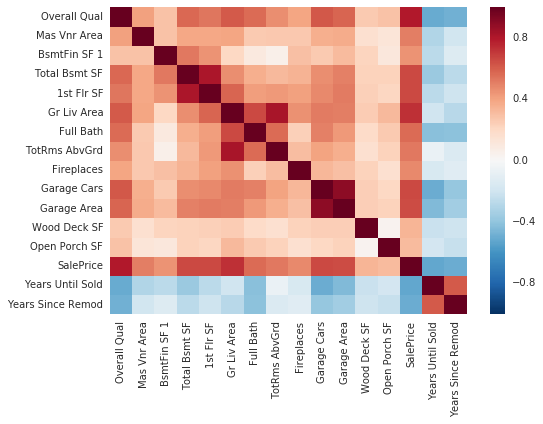

In [13]:
new_numeric = transformed_df.select_dtypes(include=[np.number])
corrs = abs(new_numeric.corr()['SalePrice'])
strong_cors = corrs[corrs > .3] #minimum +- .3 correlation 
corrmat = transformed_df[strong_cors.index].corr()
sns.heatmap(corrmat)

Strongly (over .5) positively correlated columns listed below:

In [14]:
corrmat = corrmat[corrmat['SalePrice'] > .5]['SalePrice'].sort_values(ascending = False)
corrmat

SalePrice        1.000000
Overall Qual     0.804133
Gr Liv Area      0.733590
Garage Cars      0.663178
Total Bsmt SF    0.662479
1st Flr SF       0.658570
Garage Area      0.655627
Full Bath        0.570179
TotRms AbvGrd    0.530703
Mas Vnr Area     0.512655
Name: SalePrice, dtype: float64

We also notice that the pairs (Gr Liv Area, TotRms AbvGrd) and (Garage Cars, Garage Area) exhibit signs of collinearity, which can skew our regression. So we will remove TotRms AbvGrd and Garage Cars as they aren't continuous. 

In [15]:
corrmat = corrmat.index.drop(['TotRms AbvGrd', 'Garage Cars', 'SalePrice'])

In [16]:
list(corrmat) # list of columns that have a high correlation to SalePrice

['Overall Qual',
 'Gr Liv Area',
 'Total Bsmt SF',
 '1st Flr SF',
 'Garage Area',
 'Full Bath',
 'Mas Vnr Area']

### Categorical Data Columns

We need to evaluate which nominal variable columns should be converted to categorical data (using dummy columns). Converting all of these types would add hundreds of columns to the dataframe.

We'll look for columns with a few unique values that have less than 95% of the same value. 

In [17]:
nominal_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"]
col_unique_vals = {}
for col in nominal_cols:
    if (col in transformed_df.columns):
        if (len(transformed_df[col].value_counts()) < 10):
            col_unique_vals[col] = len(transformed_df[col].value_counts())
col_unique_vals
    

{'Bldg Type': 6,
 'Central Air': 3,
 'Condition 2': 9,
 'Foundation': 7,
 'Heating': 7,
 'House Style': 9,
 'Land Contour': 5,
 'Lot Config': 6,
 'MS Zoning': 8,
 'Roof Matl': 9,
 'Roof Style': 7,
 'Street': 3}

12 columns could be good for dummy columns. Now let's check their distribution:

In [18]:
categorical_cols = []
low_variance_cols = []
for col in col_unique_vals:
    vals = transformed_df[col].value_counts(normalize = True)*100
    if vals.values[0] < 95:
        categorical_cols.append(col)
    else:
        low_variance_cols.append(col)
categorical_cols

['Central Air',
 'Lot Config',
 'MS Zoning',
 'Roof Style',
 'Bldg Type',
 'Foundation',
 'Land Contour',
 'House Style']

8 columns with enough variance to be made into dummy columns. Let's drop the unused nominal columns and examine the remaining 8:

In [19]:
transformed_df = transformed_df.drop(low_variance_cols, axis=1)
transformed_df[categorical_cols].head(1)

,Central Air,Lot Config,MS Zoning,Roof Style,Bldg Type,Foundation,Land Contour,House Style
0,Y,Corner,RL,Hip,1Fam,CBlock,Lvl,1Story


All 8 are textual columns. Let's convert to dummy columns, add them to the dataframe, and drop the originals:`

In [20]:
# Seperate text columns into dummy columns to encourage analytics
print(transformed_df.shape)
dummy_cols = pd.DataFrame()
for col in categorical_cols:
    col_dummies = pd.get_dummies(transformed_df[col])
    transformed_df = pd.concat([transformed_df, col_dummies],axis=1)
    del transformed_df[col]
    
print(transformed_df.shape)


(2927, 54)
(2927, 97)


### Update select_features & train_and_test

Finally we will update select_features with the modifications we outlined above.

We will also update our train and test / RMSE calculation to take a k-value, which will determine how we validate our data before performing our regression. 

When k=0 we will perform our holdout validation (already implemented above).

When k=1 we will perform simple cross validation (two folds, training and testing on one another, and computing average RMSE).

When k > 0, we will perform k-fold cross validation using k number of folds. 

In [67]:
def transform_features(df):
    #drop columns with 5% or more missing values
    data_null_counts = (df.isnull().sum() / len(df))
    data_null_counts = data_null_counts[data_null_counts > .05]
    df = df.drop(data_null_counts.index, axis = 1)
    
    # drop text columns with missing values
    data_missing_text = df.select_dtypes(include = ['object'])
    data_missing_text = data_missing_text.isnull().sum()
    df = df.drop(data_missing_text[data_missing_text > 0].index, axis = 1)
    
    # fill missing numeric values with column mode: 
    data_numeric = df.select_dtypes(include = [np.number])
    data_numeric = data_numeric.mode()
    df = df.fillna(data_numeric)
    df = df.fillna(0)
    
    # create new features
    years_existed = df['Yr Sold'] - df['Year Built']
    years_renovated = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Until Sold'] = years_existed
    df['Years Since Remod'] = years_renovated
    
    # remove negative rows and remove columns used for new features
    df = df.drop([1702, 2180, 2181], axis = 0) 
    df = df.drop(['Yr Sold', 'Year Remod/Add', 'Year Built'], axis = 1)
    
    # drop columns that aren't useful for ML
    df = df.drop(["PID", "Order"], axis=1)

    # drop columns that leak info about the final sale
    df = df.drop(["Mo Sold", "Sale Condition", "Sale Type"], axis=1)
    
    # normalize numeric columns:
    data_num = df.select_dtypes(include = [np.number])
    data_normalized = (data_num - data_num.min()) / (data_num.max() - data_num.min())
    
    return df

def select_features(df):
    # designate nominal columns that have less than 10 unique values
    nominal_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                        "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                        "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature", "Sale Type", "Sale Condition"]
    col_unique_vals = {}
    for col in nominal_cols:
        if (col in df.columns):
            if (len(df[col].value_counts()) < 10):
                col_unique_vals[col] = len(df[col].value_counts())
    
    # filter remaining nominal columns to those with higher variance
    categorical_cols = []
    low_variance_cols = []
    for col in col_unique_vals:
        vals = df[col].value_counts(normalize = True)*100
        if vals.values[0] < 95:
            categorical_cols.append(col)
        else:
            low_variance_cols.append(col)
    
    # drop low variance nominal columns
    df = df.drop(low_variance_cols, axis=1)
    
    # transform nominal columns to categorical and remove original columns
    dummy_cols = pd.DataFrame()
    for col in categorical_cols:
        col_dummies = pd.get_dummies(df[col])
        df = pd.concat([df, col_dummies],axis=1)
        del df[col]
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()

    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        rmse = (mean_squared_error(test['SalePrice'],predictions))**.5
        return rmse
    
    if k == 1:
        df = df.sample(frac=1).reset_index(drop=True)
        fold_one = df[:1460]
        fold_two = df[1460:]
        lr.fit(fold_one[features], fold_one['SalePrice'])
        predictions_one = lr.predict(fold_two[features])
        rmse_one = (mean_squared_error(fold_two['SalePrice'],predictions_one))**.5
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predictions_two = lr.predict(fold_one[features])
        rmse_two = (mean_squared_error(fold_one['SalePrice'],predictions_two))**.5
        return np.mean([rmse_one,rmse_two])
    
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
    
df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
transformed_df = transform_features(df)
selected_df = select_features(transformed_df)
rmse = train_and_test(selected_df, k = 10)
rmse

[50155.920219404834, 31229.97185567249, 27808.159503470255, 24593.808533392883, 28321.40145689664, 27474.4079665482, 23941.49142100155, 29160.044636104194, 29051.348449649973, 28567.820760952363]


30030.437480309338

After updating select_features and train_and_test to utilize k-fold cross validation, we were able to lower our average RMSE value to roughly 30,000 dollars (which was effectively a 45% refuction in error versus our previous attempt)! 

Additionally, we can look deeper into the rmse values and notice that at k=7, we managed to bring the RMSE all the way down to 23,491.

Given that the average home Saleprice was 180,766, this means that our method of prediction is accurate within 16.6% using average RMSE, and 13% using k=7!

In [68]:
transformed_df['SalePrice'].mean()

180766.5664502904